In [ ]:
# Clone the entire repo.
!git clone -l -s git://github.com/RobbieHolland/AIWire.git
%cd AIWire
!ls

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
# Import libraries 
import time
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

# Use full browser width
from IPython.core.display import display, HTML
display(HTML(""))

In [2]:
def show_images(outputs, n=10):
    fig = plt.figure(figsize=[10, 3])
    for i, output in enumerate(outputs[:n]):
        plt.subplot(1,n,i+1)
        plt.axis('off')
        plt.imshow(output, cmap='gray')
    plt.show()

# (Option 1) Generate data
Run the Matlab engine to call scripts that generate data

In [3]:
# python -m ipykernel install --user --name=my-virtualenv-name
import matlab.engine

# Show data
eng_start = time.time()
eng = matlab.engine.start_matlab()
print('Engine start took', time.time() - eng_start, 'seconds')

import pathlib
import os
_ = eng.addpath(os.path.join(str(pathlib.Path().absolute().parents[0]), 'simulation'))
_ = eng.addpath(os.path.join(str(pathlib.Path().absolute().parents[0]), 'simulation/util'))

Engine start took 10.160418033599854 seconds


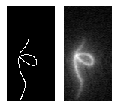

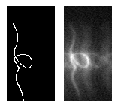

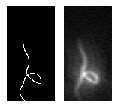

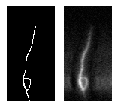

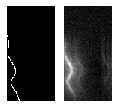

Simulation took 3.517868995666504 seconds


In [4]:
data = []

blur = 1.3
im_size = eng.cell2mat([128.0, 64.0])
sim_start = time.time()
for i in range(5):
#     pts, _ = eng.gen_spline_realistic(im_size, 100.0, 0.75, nargout = 2)
    pts, _ = eng.gen_spline_realistic(im_size, 100.0, 0.75, nargout = 2)
    ground_truth, simulated = eng.simulate(pts, im_size, 1.3, 1.0, 1.3, 10.0, 0.2, 0, 0, nargout=2)
    
    show_images([ground_truth, simulated])
    
# Most of the time is to set up the connection
print('Simulation took', time.time() - sim_start, 'seconds')

# (Option 2) Load data
Load data saved in a <tt>.mat</tt> file

In [5]:
from load_data import *
# X, y = load_data('/content/drive/My Drive/AIWIRE', 'dataset')
X, y = load_data('.', '../data/iteration_1_dataset')

In [6]:
import dataset
from sklearn.model_selection import train_test_split

batch_size = 5
test_length = round(y.shape[0] * 0.2)
X_train, y_train, X_test, y_test = X[:-test_length], y[:-test_length], X[-test_length:], y[-test_length:]
dataloaders = dataset.gen_dataloaders(X_train, X_test, y_train, y_test, batch_size)

{'train': 1600, 'val': 400}


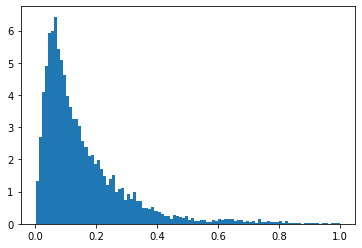

In [7]:
# Look at statistics of data
h2 = plt.hist(X_train[0].reshape(-1,1), bins = 100, density = True, alpha=1)

# Intensity-based Segmentation
Here, we use a Laplace filter to do a basic intensity based segmentation

In [90]:
# Segment data
from sklearn.mixture import GaussianMixture
import cv2

# The background and the wire
n_components = 2

# model=GaussianMixture(n_components=n_components, means_init=[[0], [0.6]])
# model.fit(X, y)

def laplace_segmentation(image, threshold = 0.6):
    lp = -cv2.Laplacian(image, cv2.CV_64F, ksize=15)
    lp = lp - np.min(lp)
    lp = lp / np.max(lp)
    return lp > threshold

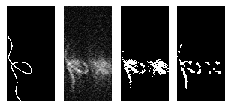

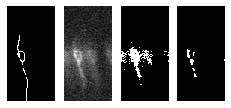

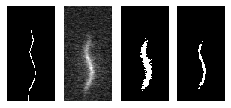

In [91]:
# Show first few segmentations
for i, (ground_truth, simulated) in enumerate(list(zip(y_test, X_test))[:3]):
    show_images([ground_truth, simulated, simulated > 0.45, laplace_segmentation(simulated)])


# Random Forest Segmentation
This is the first machine learning method we are using.

### Create the dataset
Random forests predict each patch of the image by taking as input a larger, surrounding patch (to capture context)<br>
Thus, <br>
<b>y</b>: Patches of the image <br>
<b>X</b>: Larger patches centered over each <b>y</b>

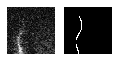

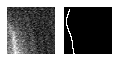

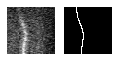

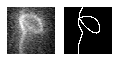

In [10]:
from random import randint

n_patches = 2000
patch_dim = 50
patches_sim, patches_gt = [], []
for i in range(n_patches):
    sample_train = X_train[i % len(X_train)]
    sample_test  = y_train[i % len(y_train)]
    tl = np.array([randint(0, sample_train.shape[i] - patch_dim - 1) for i in [0, 1]])
    patches_sim.append(sample_train[tl[0]:tl[0] + patch_dim, tl[1]:tl[1] + patch_dim])
    patches_gt.append(sample_test[tl[0]:tl[0] + patch_dim, tl[1]:tl[1] + patch_dim])

for i, (patch_sim, patch_gt) in enumerate(list(zip(patches_sim, patches_gt))[:4]):
    show_images([patch_sim, patch_gt])
    
patches_sim, patches_gt = np.array(patches_sim), np.array(patches_gt)
w = 10
c = patch_dim // 2
patch_labels = np.array([p[c - w:c + w, c - w:c + w] for p in patches_gt])
X_patches = np.array(patches_sim).reshape(n_patches,-1)
y_patches = np.array(patch_labels).reshape(n_patches,-1)

### Train random forest classifier

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

print('Class balance: ', np.sum(patch_labels) / np.prod(patch_labels.shape))
# clf = RandomForestClassifier(max_depth=100)

X_patches_train, X_patches_test, y_patches_train, y_patches_test = train_test_split(X_patches, y_patches, test_size=0.15, random_state=0)
print(X_patches_train.shape, X_patches_test.shape, y_patches_train.shape, y_patches_test.shape)

clf = RandomForestClassifier(max_depth=100, class_weight = [{0: 1, 1:10}] * y_patches_train.shape[-1])
clf.fit(X_patches_train, y_patches_train)
preds = clf.predict(X_patches_test)

Class balance:  0.04308375
(1700, 2500) (300, 2500) (1700, 400) (300, 400)


/Users/Robert/Documents/venv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### Make prediction on image
To actually segment an image, we must do so patch-by-patch<br>
Then collect the patches into the final segmentation

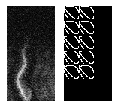

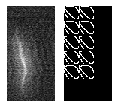

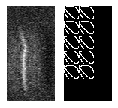

In [12]:
def rf_segmentation(image):
    test_sample = np.array(image)
    sample = np.pad(test_sample, patch_dim // 2 - w, mode='reflect')
    
    total_pred = np.zeros_like(test_sample)
    for i in range(w, test_sample.shape[0] - 2*w, 2 * w):
        for j in range(w, test_sample.shape[1] - 2*w, 2 * w):
            patch = sample[i:i + patch_dim, j:j + patch_dim]
            pred = clf.predict(patch.reshape(1,-1))

            total_pred[i-w:i+w,j-w:j+w] = pred.reshape(2 * w, 2 * w)
    return total_pred

for i in range(3):
    pred = rf_segmentation(X[i])
    show_images([X[i], pred])

# Evaluation
pts, im_size, blur, thickness, ...
   undersampling, undersampling_spread, tip_current, length_regression, verbose

In [13]:
# Load UNet
save_path = '../saved_models/model_thin'

import Unet_pytorch
num_class = 1
model = Unet_pytorch.UNet(num_class)
device = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(save_path, map_location=device))
print("Using", device)
model = model.to(device)

dataloaders = dataset.gen_dataloaders(X_train, X_test, y_train, y_test, batch_size)

Using cpu
{'train': 1600, 'val': 400}


In [40]:
def segmentation_methods(simulated):
    laplace_seg = laplace_segmentation(simulated)
    rf_seg = rf_segmentation(simulated)
    seg_net = np.zeros_like(simulated)
    unet_seg = model(torch.Tensor(simulated).unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0).detach().numpy()
    return laplace_seg, rf_seg, seg_net, unet_seg

def MSE(segmentation, ground_truth_segmentation):
    return np.square(segmentation - ground_truth_segmentation).reshape(segmentation.shape[0], -1).mean(axis = 1)
    
def evaluation_centerline(centerline, ground_truth_centerline):
    pass

In [22]:
def evaluate_method(method, metric, n = None):
    metrics = []
    for i, (simulated, ground_truth) in tqdm(enumerate(dataloaders['val'])):
        if n is not None and i >= n:
            break
        segmented = method(simulated.float().squeeze(1).detach().numpy())
        metrics.append(metric(segmented, ground_truth.numpy()))
    return np.array(metrics).mean()

In [24]:
methods = {'Laplace filter': lambda x: np.array([laplace_segmentation(x_i) for x_i in x]),
           'Random forest': lambda x: np.array([rf_segmentation(x_i) for x_i in x]),
           'UNet': lambda x: model(torch.Tensor(x).unsqueeze(1)).detach()}

for name, method in methods.items():
    score = evaluate_method(method, MSE, n = 20).mean()
    print(f'{name} had MSE of {score}')


Laplace filter had MSE of 0.055126953125



Random forest had MSE of 0.123792724609375


UNet had MSE of 0.03104869264269495


## Ablation study

Varying Tip current
Evaluation took 7.145666122436523 seconds


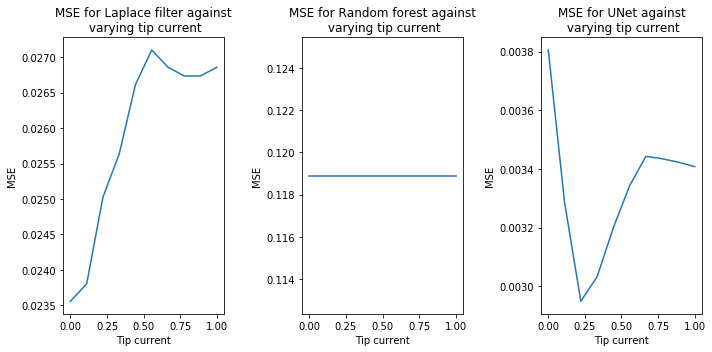

In [92]:
n_values = 10
im_size = eng.cell2mat([128.0, 64.0])
loop_prob = 0.75
eng.addpath('util/')

def evaluate_ablation(methods, metric, parameters, rng=1235):
    eng.rng(rng)
    pts, _ = eng.gen_spline_realistic(im_size, 100.0, 0.75, nargout = 2)
    
    blur = [1.3] * n_values
    undersampling = [1.3] * n_values
    undersampling_spread = [10.0] * n_values
    # tip_current = [0.2] * n_values
    tip_current = np.linspace(0, 1, num=n_values).tolist()
    variants = [v for v in parameters.keys() if len(np.unique(parameters[v])) > 1]
    if len(variants) != 1:
        print(f'Warning, varying {len(variants)} parameter(s)')
    variant = variants[0]
    print(f'Varying {variant}')

    sim_start = time.time()
    simulated_images, ground_truths = [], []
    for b, u, us, tc in np.array(list(parameters.values())).T.tolist():
        eng.rng(rng)
        ground_truth, simulated = np.array(eng.simulate(pts, im_size, b, 1.0, u, us, tc, 0, 0, nargout=2))
        simulated_images.append(simulated)
        ground_truths.append(ground_truth)

    simulated_images, ground_truths = np.array(simulated_images), np.array(ground_truths)
    # scores = {}
    for name, method in methods.items():
        segmented = method(simulated_images)
        scores[name] = metric(segmented, ground_truths)

    fig = plt.figure(figsize=[10, 5])
    for i, method in enumerate(methods.keys()):
        plt.subplot(1,len(methods),i+1)
        plt.plot(parameters[variant], scores[method], label = method)
        plt.title(f'{metric.__name__} for {method} against\n varying tip current')
        plt.xlabel(variant)
        plt.ylabel(metric.__name__)
    plt.tight_layout()
    # Most of the time is to set up the connection
    print('Evaluation took', time.time() - sim_start, 'seconds')

parameters = {}
parameters['Blur'] = [1.3] * n_values
parameters['Undersampling'] = [1.3] * n_values
parameters['Undersampling spread'] = [10.0] * n_values
parameters['Tip current'] = np.linspace(0, 1, num=n_values).tolist()
evaluate_ablation(methods, MSE, parameters, rng = 100)